# Introduction

Using historical data on loans from Lendig Club - including information on whether or not the borrower defaulted (charge-off) - the main objective of this notebook will be to predict if a potential borrower is likely to pay back the loan.

After explore and pre-process data, we are going to train a Neural Network binary classification model in order to achive this objective. Finally, we evaluate model performance and simulate its operation with a new customer prediction. 

Notebook sections:

1. <a href="#sec1"> Import data </a>
2. <a href="#sec2"> Exploratory Data Analysis </a>
3. <a href="#sec3"> Pre-processing </a>
4. <a href="#sec4"> Define and train Model </a>
5. <a href="#sec5"> Evaluate Model </a>


p.s. work inspired by the excellent <a href="https://www.udemy.com/course/complete-tensorflow-2-and-keras-deep-learning-bootcamp/"> Tf2 and Keras DL Bootcamp </a>

<a id="sec1"></a>
# Importing data

In [8]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


<a id="sec2"></a>

# Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [ ]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

for the sake of simplicity, let's consider only _Fully Paid_ and _Charged Off_ values:

In [ ]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


<AxesSubplot:xlabel='loan_status', ylabel='count'>

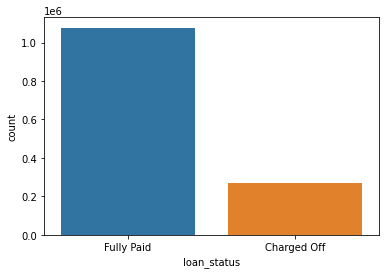

In [ ]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
fico_range_high                                     0
fico_range_low                                      0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
hardship_type                                 1339556
hardship_reason                               1339556
hardship_status                               1339556
deferral_term                                 1339556
hardship_amount                               1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_payoff_balance_amount                1339556
hardship_last_payment_amount                  1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [ ]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

total_bal_il                  807712
open_act_il                   807712
open_rv_12m                   807712
open_rv_24m                   807712
inq_fi                        807712
open_il_12m                   807712
open_il_24m                   807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
mo_sin_rcnt_rev_tl_op          67528
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_il_tl                      67527
num_accts_ever_120_pd          67527
num_bc_tl                      67527
total_il_high_credit_limit     67527
num_rev_tl_bal_gt_0            67527
num_op_rev_tl                  67527
tot_cur_bal                    67527
t

maybe we can go further, and eliminate columns up to title:

In [ ]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

for the remaining columns with missing values, let's see the missing percentage:

In [ ]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. 
Let's remove the rows that are missing those values in those columns with dropna():

In [ ]:
df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [ ]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

let's now take a look at loan_amnt histogram, to have an idea of the amount distribution:

<AxesSubplot:xlabel='loan_amnt', ylabel='Count'>

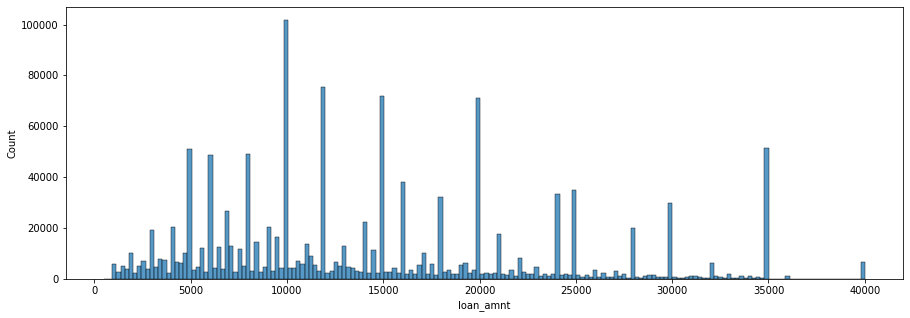

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(df_accepted.loan_amnt, kde=False)

let's now see the correlation between continuous variables:

<AxesSubplot:>

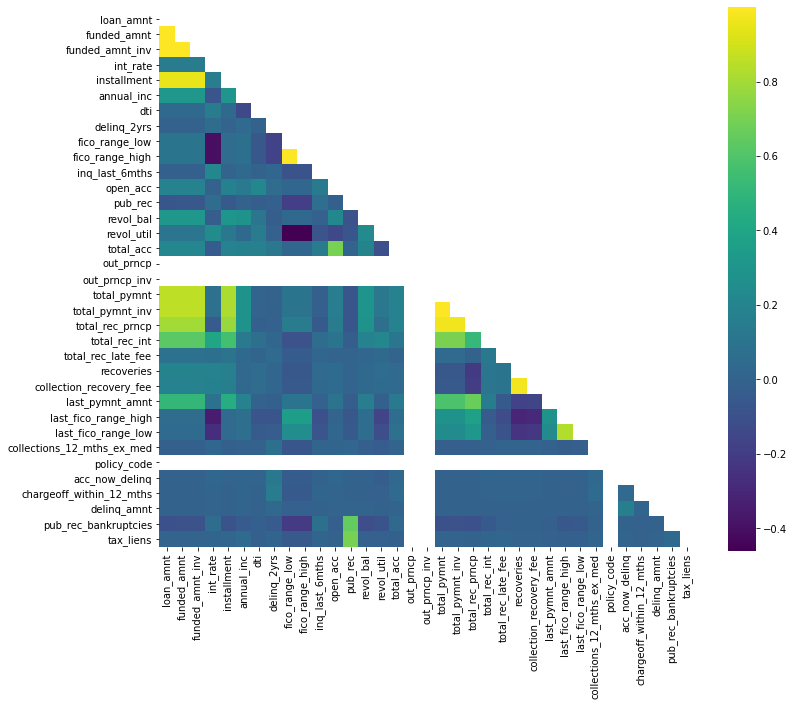

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

there are 3 columns with a visible different behaviour:
out_prncp, out_prncp_inv and policy_code.

In [ ]:
print(df_accepted.out_prncp.value_counts())
print(df_accepted.out_prncp_inv.value_counts())
print(df_accepted.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


> These are constant columns. We can drop it either.

In [ ]:
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

<AxesSubplot:>

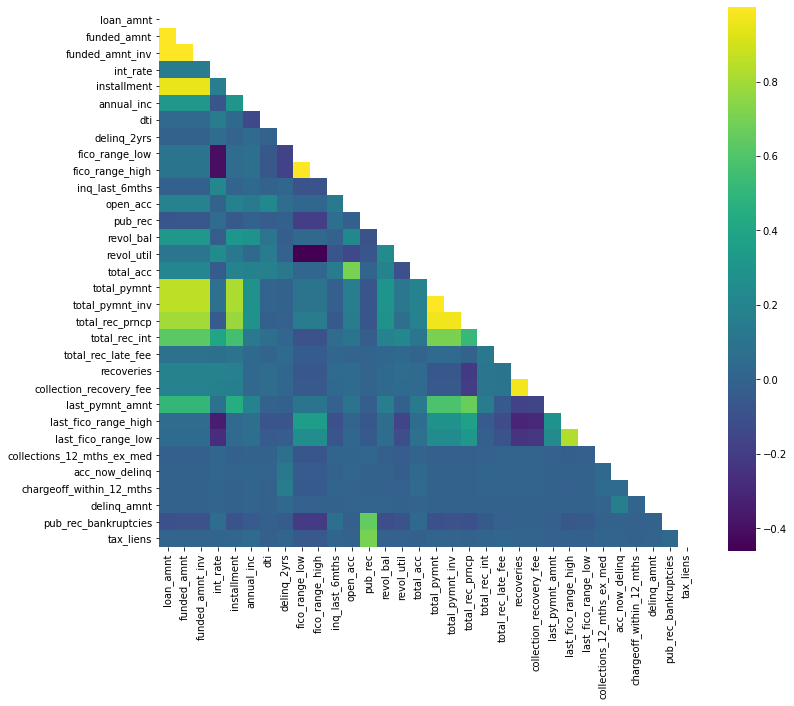

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

There are many yellowish squares. This indicates almost perfect correlation between many variables. Let's dig deeper:

In [ ]:
# unstacking correlation to check highest correlation pairs

c = df_accepted.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

,feature1,feature2,corr
1,fico_range_low,fico_range_high,1.000000
2,funded_amnt,loan_amnt,0.999565
3,total_pymnt_inv,total_pymnt,0.999541
4,funded_amnt_inv,funded_amnt,0.999439
5,funded_amnt_inv,loan_amnt,0.998918
6,recoveries,collection_recovery_fee,0.972674
7,total_pymnt,total_rec_prncp,0.967104
8,total_rec_prncp,total_pymnt_inv,0.966725
9,funded_amnt,installment,0.954037
10,installment,funded_amnt_inv,0.953445


Let's perform scatterplot and visually check some relationships among these features:

<AxesSubplot:xlabel='fico_range_low', ylabel='fico_range_high'>

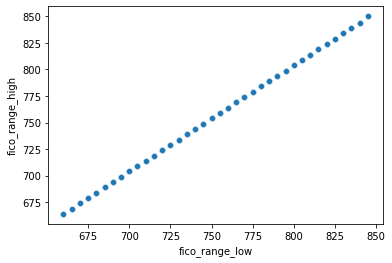

In [ ]:
sns.scatterplot(x=df_accepted.fico_range_low, y=df_accepted.fico_range_high)

<AxesSubplot:xlabel='funded_amnt', ylabel='loan_amnt'>

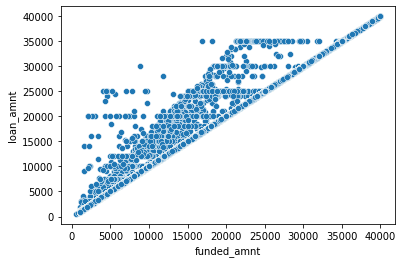

In [ ]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.loan_amnt)

<AxesSubplot:xlabel='funded_amnt', ylabel='funded_amnt_inv'>

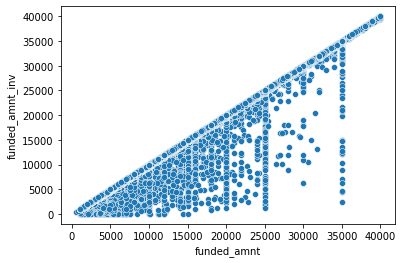

In [ ]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.funded_amnt_inv)

<AxesSubplot:xlabel='total_pymnt', ylabel='installment'>

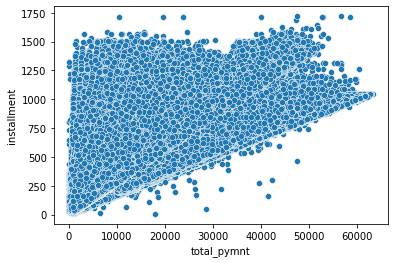

In [ ]:
sns.scatterplot(x=df_accepted.total_pymnt, y=df_accepted.installment)

It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

In [ ]:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

as our target column is categorical (loan_status), let's create a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [ ]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [ ]:
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

<AxesSubplot:>

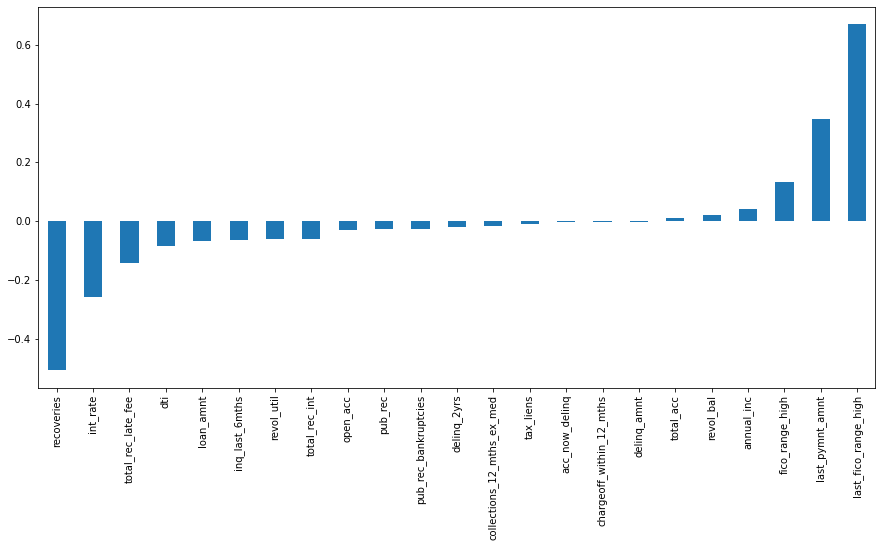

In [ ]:
# checking correlation of features to the new loan_paid column


plt.figure(figsize=(15,7))
new_corr = df_accepted.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

<a id="sec3"></a>

# Pre-processing

we still have many string categorical columns. Let's work on it:

In [ ]:
df_accepted.head()

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1


In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)
df_accepted[cat_cols]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Aug-2018,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Mar-2017,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2018,Mar-2019,Individual,N,Cash,N


In [ ]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### feature "term"

In [ ]:
print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [ ]:
df_accepted['term']

0          36
1          36
2          60
4          60
5          36
           ..
2260688    60
2260690    60
2260691    60
2260692    60
2260697    60
Name: term, Length: 1341026, dtype: int64

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### features "grade" and "sub_grade"

In [ ]:
print(df_accepted.grade.value_counts())
print(df_accepted.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


<AxesSubplot:xlabel='grade', ylabel='count'>

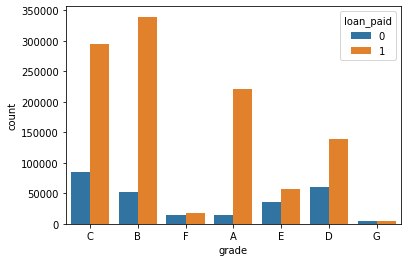

In [ ]:
# checking count per grade and loan_paid

sns.countplot(x=df_accepted.grade, hue=df_accepted.loan_paid)

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

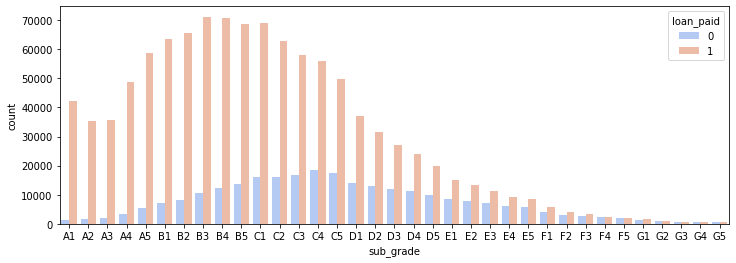

In [ ]:
# checking count per subgrade and loan_paid

l = list(df_accepted.sub_grade.unique())
l.sort()

plt.figure(figsize=(12,4))
sns.countplot(x=df_accepted.sub_grade, order=l, hue=df_accepted.loan_paid, palette='coolwarm')

In [ ]:
# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

In [ ]:
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


### features verification_status, application_type, initial_list_status, purpose 

In [ ]:
print(df_accepted.verification_status.unique())
print(df_accepted.application_type.unique())
print(df_accepted.initial_list_status.unique())
print(df_accepted.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [ ]:
# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


### feature home_ownership

In [ ]:
df_accepted.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [ ]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['issue_d', 'url', 'zip_code', 'addr_state', 'earliest_cr_line',
       'last_pymnt_d', 'last_credit_pull_d', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### features issue_d, url, last_pymnt_d and last_credit_pull_d

In [ ]:
df_accepted.issue_d.head(10)

0     Dec-2015
1     Dec-2015
2     Dec-2015
4     Dec-2015
5     Dec-2015
6     Dec-2015
7     Dec-2015
8     Dec-2015
9     Dec-2015
12    Dec-2015
Name: issue_d, dtype: object

In [ ]:
df_accepted = df_accepted.drop(columns=['issue_d', 'url', 'last_pymnt_d', 'last_credit_pull_d'])

### features zip_code and addr_state

In [ ]:
df_accepted.zip_code.value_counts()

945xx    14964
750xx    14440
112xx    13781
606xx    12407
300xx    12087
         ...  
513xx        1
507xx        1
819xx        1
429xx        1
892xx        1
Name: zip_code, Length: 943, dtype: int64

In [ ]:
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['earliest_cr_line', 'disbursement_method', 'debt_settlement_flag'], dtype='object')


### features disbursement_method and debt_settlement_flag

In [ ]:
print(df_accepted.disbursement_method.value_counts())
print(df_accepted.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


In [ ]:
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

### feature earliest_cr_line

In [ ]:
print(df_accepted.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Mar-1958       1
Dec-1950       1
Aug-1951       1
Feb-1957       1
Mar-1954       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [ ]:
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

<a id="sec4"></a>

# Creating a Neural Network Model

now we are ready to start our modelling phase. First, let's apply a train-test-split and scale data before training.

In [ ]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted.copy()

X = df.loc[:, df.columns != 'loan_paid'].values
y = df.loan_paid.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1072820, 81)
(268206, 81)


In [ ]:
# building the model

model = Sequential()
model.add(Dense(units=78,activation='relu'))
model.add(Dense(units=39,activation='relu'))
model.add(Dense(units=19,activation='relu'))
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=4,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=40,
          batch_size=512,
          validation_data=(X_test, y_test), verbose=1)

Epoch 1/40
2096/2096 [==============================] - 9s 4ms/step - loss: 0.2228 - accuracy: 0.9122 - val_loss: 0.0814 - val_accuracy: 0.9678
Epoch 2/40
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0797 - accuracy: 0.9688 - val_loss: 0.0692 - val_accuracy: 0.9736
Epoch 3/40
2096/2096 [==============================] - 9s 4ms/step - loss: 0.0708 - accuracy: 0.9729 - val_loss: 0.0650 - val_accuracy: 0.9753
Epoch 4/40
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0660 - accuracy: 0.9749 - val_loss: 0.0627 - val_accuracy: 0.9761
Epoch 5/40
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0632 - accuracy: 0.9760 - val_loss: 0.0598 - val_accuracy: 0.9776
Epoch 6/40
2096/2096 [==============================] - 9s 4ms/step - loss: 0.0594 - accuracy: 0.9777 - val_loss: 0.0569 - val_accuracy: 0.9792
Epoch 7/40
2096/2096 [==============================] - 9s 4ms/step - loss: 0.0567 - accuracy: 0.9791 - val_loss: 0.0623 - val_accuracy:

<a id="sec5"></a>

# Evaluate model

In [ ]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

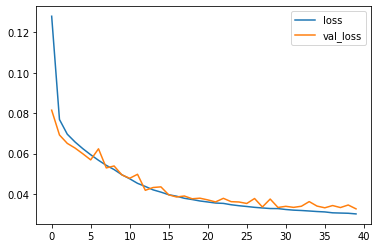

In [ ]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

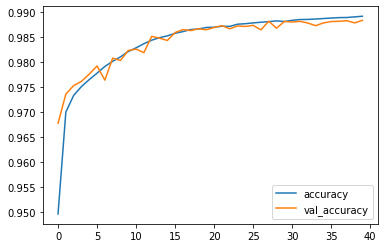

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     53089
           1       0.99      0.99      0.99    215117

    accuracy                           0.99    268206
   macro avg       0.98      0.98      0.98    268206
weighted avg       0.99      0.99      0.99    268206



In [ ]:
pd.DataFrame(confusion_matrix(y_test, predictions))

,0,1
0,51255,1834
1,1296,213821


### simulating a new customer

In [ ]:
import random

df_accepted = df_accepted.reset_index(drop=True)

random.seed(101)
random_ind = random.randint(0,len(df_accepted))

new_customer = df_accepted.drop('loan_paid',axis=1).iloc[random_ind]
new_customer

loan_amnt      29675.00
term              36.00
int_rate          10.99
annual_inc    125565.00
dti                7.67
                ...    
OTHER              0.00
OWN                0.00
RENT               0.00
DirectPay          0.00
Y                  0.00
Name: 1218764, Length: 81, dtype: float64

In [ ]:
new_c = scaler.transform(new_customer.values.reshape(1,81))

print(f"model prediction: {(model.predict(new_c) > 0.5).astype('int32')[0][0]}")

model prediction: 1


In [ ]:
# checking if this customer paid his loan

df_accepted.loc[random_ind, 'loan_paid']

1